In [1]:
#https://docs.ray.io/en/latest/train/examples/train_fashion_mnist_example.html

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor, Resize,Compose, ToPILImage

from sklearn.metrics import classification_report, confusion_matrix

import ray
from ray import train
import ray.train.torch
from ray.train import Trainer
from ray.train import CheckpointStrategy
from ray.data.datasource import SimpleTorchDatasource

import matplotlib.pyplot as plt

Package pickle5 becomes unnecessary in Python 3.8 and above. Its presence may confuse libraries including Ray. Please uninstall the package.


In [3]:
ray.init('ray://{ray_head}:10001'.format(ray_head=os.environ['RAY_CLUSTER']))

ClientContext(dashboard_url='10.128.4.46:8265', python_version='3.8.12', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', protocol_version='2022-03-16', _num_clients=1, _context_to_restore=<ray.util.client._ClientContext object at 0x7fb83b1a5370>)

In [4]:
transforms = Compose([Resize((64,64)),ToTensor()])

In [5]:
pet_data = torchvision.datasets.OxfordIIITPet("data/",download = True ,  target_types = "category", transform = transforms, split = "trainval")

In [6]:
data_loader = torch.utils.data.DataLoader(pet_data, batch_size=4, shuffle=True)

This data set is only 3K and not the full 7k since we read in dataset with the `split` parameters that pulls in the files based on the corresponding txt file in `data/data/oxford-iiit-pet/annotations`

In [7]:
len(pet_data)

3680

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device = "cpu"

cuda:0


Feature batch shape: torch.Size([4, 3, 64, 64])
Labels batch shape: torch.Size([4])


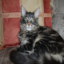

label:20


In [9]:
train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')

In [10]:
# modified from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3,1 )
        
        self.fc1 = nn.Linear(6272 , 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 37)
        
        self.dropout1 = nn.Dropout(0.25)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool((self.conv1(x)))
        x = self.pool((self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        y_pred = self.fc3(x)
        return y_pred



In [11]:
net = ConvNet()
net.to(device)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=37, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
def train_x(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [14]:
%time
for epoch in range(2):
    train_x(net,device,data_loader, optimizer, epoch) 
    
state_dict = net.state_dict()
consume_prefix_in_state_dict_if_present(state_dict, "module.")        

print('Finished Training')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
Train Epoch: 0 [0/3680 (0%)]	Loss: 3.598244
Train Epoch: 1 [0/3680 (0%)]	Loss: 3.626917
Finished Training


In [15]:
model_scripted = torch.jit.script(net)
model_scripted.save('model_scripted.pt')

In [16]:
# Now with Ray 

In [ ]:
dataset_factory = lambda: torchvision.datasets.OxfordIIITPet("data/", download = True, target_types = "category", transform = transforms, split = "trainval")
dataset = ray.data.read_datasource(
    SimpleTorchDatasource(), parallelism=1, dataset_factory=dataset_factory
)

In [18]:
x = dataset.random_shuffle().repartition(2).split(2)
x

Repartition: 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


[Dataset(num_blocks=1, num_rows=1840, schema=<class 'tuple'>),
 Dataset(num_blocks=1, num_rows=1840, schema=<class 'tuple'>)]

In [19]:
train_data = x[0]
test_data = x[1]

In [20]:
def train_epoch(dataloader, model, loss_fn, optim):
    model.train()
    for batch_idx, data in enumerate(dataloader.iter_batches()):
        X = [x[0] for x in data]
        X = torch.stack(X)
        X = X.to("cuda")
        y = [torch.tensor(x[1]) for x in data]
        y = torch.stack(y)
        y = y.to("cuda") 
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    return loss.item()

In [21]:
def validate_epoch(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data in dataloader.iter_batches():
            X = [x[0] for x in data]
            X = torch.stack(X)
            X = X.to("cuda")
            y = [torch.tensor(x[1]) for x in data]
            y = torch.stack(y)
            y = y.to("cuda")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()  
    
    return test_loss/dataloader.num_blocks()

            

In [22]:
def train_func(config):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["epochs"]
    momentum = config["momentum"]
    
    
    train_dataloader = train_data
    test_dataloader = test_data
    model = ConvNet()
    model = train.torch.prepare_model(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr,  momentum=momentum)
    
    loss_results = []
    eval_results = []
    
    for epoch in range(epochs):
        loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
        val_loss = validate_epoch(test_dataloader, model, loss_fn)
        #train.report(loss=val_loss)
        loss_results.append(loss)
        eval_results.append(val_loss)
        if epoch % 100 == 0:
            print(f"epoch:{epoch}  loss {loss:>7f}")
            print(f"eval loss: {val_loss:>7f}")    
            
        if epoch == epochs-1:
            state_dict = model.state_dict()
            consume_prefix_in_state_dict_if_present(state_dict, "module.")
            train.save_checkpoint(epoch=epochs, model_weights=state_dict)
    
    return loss_results, eval_results
            
    

In [23]:
%%time
if os.environ.get('RAY_CLUSTER') is not None:
    num_workers = 2
else:
    num_workers = 1
    
use_gpu = torch.cuda.is_available()

trainer = Trainer(backend="torch", num_workers=num_workers, use_gpu=use_gpu)

2022-08-17 20:16:27,521	INFO trainer.py:243 -- Trainer logs will be logged in: /opt/app-root/src/ray_results/train_2022-08-17_20-16-27


CPU times: user 10.1 ms, sys: 1.01 ms, total: 11.1 ms
Wall time: 601 ms


In [ ]:
%%time
trainer.start()# This keeps starting new workers 

In [ ]:
%%time
loss, eval_ = trainer.run(train_func=train_func,
        config={"lr": 0.01, "batch_size": 4, "epochs": 300, "momentum":0.9})


In [26]:
results = trainer.latest_checkpoint
#torch.save(results["model_weights"], "dist_model.torch")

In [27]:
%%time
trainer.shutdown()

CPU times: user 1.97 ms, sys: 29 µs, total: 2 ms
Wall time: 44 ms


(BaseWorkerMixin pid=1029) E0817 20:19:56.516866870    1056 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


2022-08-17 20:19:56,532	INFO common.py:219 -- Exception from actor creation is ignored in destructor. To receive this exception in application code, call a method on the actor reference before its destructor is run.
(BaseWorkerMixin pid=171, ip=10.128.2.151) E0817 20:19:56.516900257     199 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


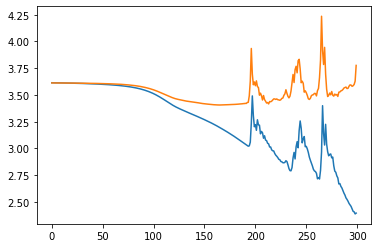

In [28]:
plt.plot(loss[0])
plt.plot(eval_[1])
plt.show()

In [29]:
model = ConvNet()
model.load_state_dict(results["model_weights"])
model_scripted = torch.jit.script(model)
model_scripted.save('models/ray_model_scripted.pt')

In [30]:
model = torch.jit.load("models/ray_model_scripted.pt", map_location=torch.device('cpu')).eval()

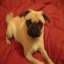

label:25
prediction: 25


In [31]:
train_features, train_labels = next(iter(data_loader))
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')
logits = model(train_features[0].reshape(1,3,64,64).to(device))
print(f"prediction: {torch.argmax(logits).item()}")

In [32]:
y_preds = []
gt = []
for X,y in data_loader:
    logits = model(X[0].reshape(1,3,64,64).to(device))
    y_pred = torch.argmax(logits).item()
    y_preds.append(y_pred)
    gt.append(y[0].item())

In [33]:
for data in test_data.iter_batches():
    X = [x[0] for x in data]
    X = torch.stack(X)
    X = X.to("cpu")
    y = [torch.tensor(x[1]) for x in data]
    y = torch.stack(y)
    logits = model(X.to(device))
    y_preds = torch.argmax(logits, dim=1)
    y_preds = y_preds.to("cpu")

In [34]:
print(classification_report(y_preds,y))

              precision    recall  f1-score   support

           0       0.12      0.08      0.09        78
           1       0.02      0.04      0.03        23
           2       0.04      0.09      0.05        22
           3       0.13      0.14      0.13        51
           4       0.16      0.09      0.11        79
           5       0.00      0.00      0.00        18
           6       0.09      0.10      0.09        40
           7       0.40      0.23      0.30        77
           8       0.02      0.02      0.02        42
           9       0.39      0.09      0.15       211
          10       0.12      0.09      0.10        64
          11       0.10      0.07      0.08        73
          12       0.02      0.04      0.03        23
          13       0.02      0.02      0.02        44
          14       0.05      0.07      0.06        40
          15       0.14      0.15      0.14        48
          16       0.00      0.00      0.00         1
          17       0.04    

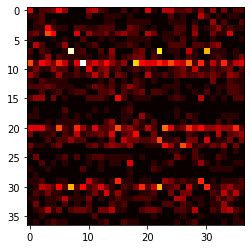

In [35]:
plt.imshow(confusion_matrix(y_preds,y), cmap='hot', interpolation='nearest')
plt.show()

In [36]:
print(f"Accuracy: {np.sum(np.array(y_preds)==np.array(y))/(len(y))*100:.1f}%")
print(f"Random guess would yield {(1/37)*100:.1f}%")
print(f"Model outperforms Random chance by a factor of {(np.sum(np.array(y_preds)==np.array(y))/len(y))/(1/37):.2f}")

Accuracy: 8.2%
Random guess would yield 2.7%
Model outperforms Random chance by a factor of 3.04
